In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import sklearn
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

In [52]:
def get_stock(start, end, stock, restricted_days):
    '''
    Return the data as Numpy arrays and incrementing indexes for each value for the time series.

    Parameters:
    -- start: start date "Year-Month-Day"
    -- end: end date "Year-Month-Day"
    -- stock: The label of the stock to download from yahoo stocks
    -- restriced_days: int, the number of last days to be removed from the dataframe 

    Returns:
    -- df: 1d Numpy array containing all the closing prices from the start to end data except for the last 100 days
    -- restricted_df: Contains the last <restriced_days> days of the data
    -- index: incrementing indexes for the closing prices
    '''
    
    yfd = yf.download(stock, start=start, end=end)
    df = pd.DataFrame({'Close': yfd['Close']})
    df = df.dropna().reset_index(drop=True)

    restricted_df = np.array(df[len(df) - restricted_days:]) # last 100 days prices
    df = np.array(df[:len(df) - restricted_days]) # remove the restricted days from the main df
    index = np.linspace(1, df.shape[0], df.shape[0])

    return df, restricted_df, index 

def bin_data(df, bin_size):
    '''
    Returns the data split into bins of size <bin_size>. The bins are used to predict the day on index <bin_size> + 1.
    
    Parameters:
    -- df: dataset containing the closing prices for the stock
    -- bin_size: size of bins for the data

    Returns:
    -- bins: Numpy array size (len(df) - bin_size, bin_size), bins created based on a sliding window incrementing by 1
    '''
    
    bins = np.array([df[i:i + bin_size].T.reshape(-1) for i in range(0, len(df) - bin_size - 1, 1)])
    return bins 

def split_data(bins, df, index):
    # Generally it is good practice to train data on 80 % of the data and test on 20%
    train_size = math.floor(len(bins)* 0.8) # 80% of the data
    test_size = len(bins) - train_size # 20% of the data
    assert train_size + test_size == len(bins)
    
    # split into X and y
    X_train = np.array(bins[:train_size])
    y_train = np.array(df[bin_size:bin_size + train_size]).T.reshape(-1)
    train_index = index[:train_size]
    
    X_test = np.array(bins[train_size:])
    y_test = np.array(df[bin_size + train_size: bin_size + train_size + test_size]).T.reshape(-1) # the value after the bin_size
    test_index = index[train_size + 1: train_size + 1 + test_size]

    return X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size
    

def test_stock(stock, restrict=100, bin_size=365):

    # Get the stock data
    df, restricted_df, index = get_stock(stock[1], stock[2], stock[0], restrict)

    # Create bins
    bins = bin_data(df, bin_size)

    # Split the data
    X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index)

    # Run the linear model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = np.floor(model.predict(X_test))
    y_test = np.floor(y_test)

    ''' Auto-regressive '''
    running_bin = bins[-1].copy()
    next_predictions = []
    for i in range(restrict): # predict the next 100 days
        prediction = model.predict([running_bin])
    
        # feed the prediction back into the input
        running_bin[:-1] = running_bin[1:]
        running_bin[-1] = prediction[0]
    
        # store predictions
        next_predictions.append(prediction[0])
    
    # print(next_predictions[-10:])
    days = np.arange(1, len(next_predictions) + 1)
    
    
    plt.figure()
    plt.title(f"{stock[0]} stock")
    plt.plot(days, next_predictions, label = "Auto-Regressive")
    plt.plot(days, restricted_df, label = f"Actual")
    plt.xlabel(f"Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [31]:
''' Define stocks '''
# [name, start-date, end-date]
stock = ['^GSPC', '1980-01-01', '2024-10-01']
restrict = 100 # Use the last 100 days for autoregressive testing
bin_size = 365 # We require the past year of data

df, restricted_df, index = get_stock(stock[1], stock[2], stock[0], restrict)

[*********************100%***********************]  1 of 1 completed


# Visualize The Data

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5127.79003906]
 [5180.74023438]
 [5187.70019531]] (11181, 1)
(11181,) (11181,)


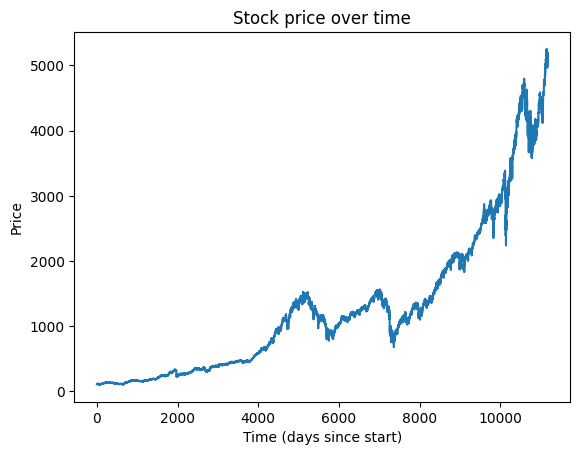

In [20]:
print(df, df.shape)
print(index.shape, df.T[0].shape)

plt.plot(index, df.T[0])
plt.title("Stock price over time")
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.show()


# Split the data into bins

In [21]:
bins = bin_data(df, bin_size)

print(bins.shape)
print(bins[0][:5], bins[0].shape)
print(bins[1][:5], bins[1].shape)
print()
print(bins[-1][-10:])

(10815, 365)
[105.76000214 105.22000122 106.51999664 106.80999756 108.94999695] (365,)
[105.22000122 106.51999664 106.80999756 108.94999695 109.05000305] (365,)

[5010.60009766 5070.54980469 5071.62988281 5048.41992188 5099.95996094
 5116.16992188 5035.68994141 5018.39013672 5064.20019531 5127.79003906]


# Split Data: Train and Test

In [22]:
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index)

print("train_size:", train_size)
print("test_size:", test_size)
print("x_size:", X_train.shape, X_test.shape)
print("y_size:", y_train.shape, y_test.shape)

train_size: 8652
test_size: 2163
x_size: (8652, 365) (2163, 365)
y_size: (8652,) (2163,)


# Train the linear model

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_) # weights
print(model.intercept_) # bias

[ 1.07291997e-02 -1.01158440e-03  2.32132316e-02 -3.55071723e-02
  1.10556267e-02 -1.00953372e-02  2.92347293e-03 -4.77019345e-03
  8.23115324e-03 -7.98818955e-03 -1.35311606e-02  2.56404146e-02
  5.24680125e-03 -8.48901105e-03 -9.66405169e-04 -9.71230178e-03
  1.14244970e-02 -9.00924701e-03  1.33942966e-02 -2.22112177e-02
  2.21361107e-02 -3.04837705e-03  1.18936653e-03  1.38965473e-02
 -5.95970763e-02  1.46626548e-02  1.18033356e-02 -6.39515229e-04
 -1.70493601e-02  2.97801974e-02 -1.15858056e-02 -6.62268010e-04
 -7.29140000e-03  2.13972411e-02  1.43372256e-02 -3.06623770e-03
 -1.88824552e-02 -1.18948764e-02 -5.20298601e-03  2.92396362e-02
  3.00500071e-03 -6.11337679e-03 -5.84271185e-03 -1.15238712e-02
  3.52941014e-02 -2.36992092e-02  1.06612236e-02 -2.75269419e-02
 -2.19962583e-03  2.82282329e-02 -1.77998125e-02  2.41321375e-02
 -1.27229810e-02 -2.09505360e-02  3.42817359e-02  1.60870681e-04
 -2.30829924e-02  2.85374414e-02 -7.77260395e-03 -2.70875759e-02
  1.47225673e-02 -2.39023

In [24]:
# now we make some predictions
# y_pred = 0
# for i in range(len(y_test)):
#     y_pred = model.predict([X_test[i]])
#     print(y_pred, y_test[i])

y_pred = np.floor(model.predict(X_test))
y_test = np.floor(y_test)
print(y_pred.shape, y_test.shape)

for i in range(math.floor(len(y_pred) * 0.01)):
    print("prediction:", y_pred[i], "| actual:", y_test[i], "| difference:", abs(y_pred[i] - y_test[i]))
# print(y_pred)
print(X_test.shape)


(2163,) (2163,)
prediction: 1925.0 | actual: 1923.0 | difference: 2.0
prediction: 1919.0 | actual: 1951.0 | difference: 32.0
prediction: 1943.0 | actual: 1987.0 | difference: 44.0
prediction: 1984.0 | actual: 1979.0 | difference: 5.0
prediction: 1976.0 | actual: 1995.0 | difference: 19.0
prediction: 1995.0 | actual: 2013.0 | difference: 18.0
prediction: 2015.0 | actual: 2014.0 | difference: 1.0
prediction: 2021.0 | actual: 2017.0 | difference: 4.0
prediction: 2020.0 | actual: 2003.0 | difference: 17.0
prediction: 1992.0 | actual: 1994.0 | difference: 2.0
prediction: 1990.0 | actual: 2023.0 | difference: 33.0
prediction: 2018.0 | actual: 2033.0 | difference: 15.0
prediction: 2038.0 | actual: 2033.0 | difference: 5.0
prediction: 2030.0 | actual: 2030.0 | difference: 0.0
prediction: 2029.0 | actual: 2018.0 | difference: 11.0
prediction: 2025.0 | actual: 2052.0 | difference: 27.0
prediction: 2052.0 | actual: 2075.0 | difference: 23.0
prediction: 2076.0 | actual: 2071.0 | difference: 5.0
pr

# Results
As can be seen, the results are relatively close to the actual values if we adjust for a small margin of error.

(8652,) (2163,)


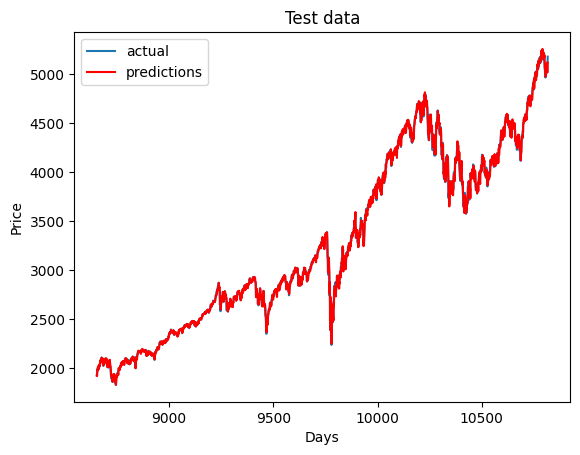

Correctly Classified: 1842/2163
Accuracy: 85.15950069348128%, error_margin of $50
Correctly Classified: 2105/2163
Accuracy: 97.31853906611188%, error_margin of $100


In [25]:
print(train_index.shape, test_index.shape)
plt.plot(test_index, y_test, label="actual")
plt.plot(test_index, y_pred, color="red", label="predictions")
plt.title("Test data")
plt.ylabel("Price")
plt.xlabel("Days")
plt.legend()
plt.show()

error_margin = 50
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

error_margin = 100
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

In [26]:
print(f"Tomorrows Price: {y_pred[-1]}")
print(y_pred[-15:])
print(y_test[-15:])

Tomorrows Price: 5120.0
[5079. 5058. 5028. 5020. 4976. 5003. 5042. 5079. 5030. 5101. 5112. 5049.
 5018. 5070. 5120.]
[5051. 5022. 5011. 4967. 5010. 5070. 5071. 5048. 5099. 5116. 5035. 5018.
 5064. 5127. 5180.]


# Autoregressive

We previously restricted the last 100 days from our data and we use it to test our auto regressive model that feeds the prediction back into the data. 

[5061.81982422 5051.41015625 5022.20996094 5011.12011719 4967.22998047
 5010.60009766 5070.54980469 5071.62988281 5048.41992188 5099.95996094
 5116.16992188 5035.68994141 5018.39013672 5064.20019531 5127.79003906] (10815, 365)


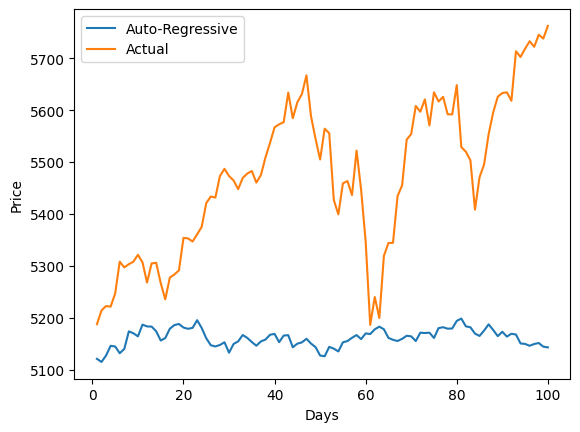

First few days


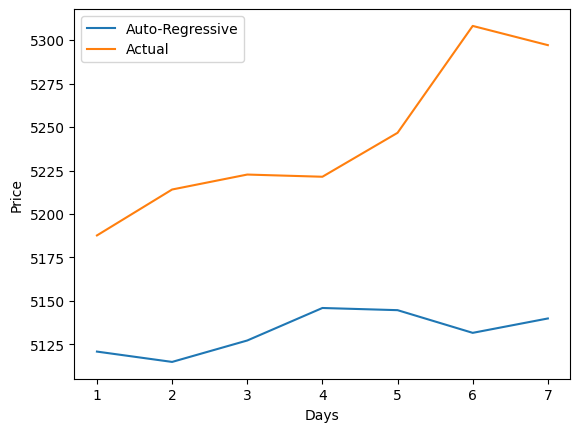

In [27]:
# take the last bin and perform a prediction
print(bins[-1][-15:], bins.shape)

running_bin = bins[-1].copy()

next_predictions = []
for i in range(restrict): # predict the next 100 days
    prediction = model.predict([running_bin])

    # feed the prediction back into the input
    running_bin[:-1] = running_bin[1:]
    running_bin[-1] = prediction[0]

    # store predictions
    next_predictions.append(prediction[0])

# print(next_predictions[-10:])
days = np.arange(1, len(next_predictions) + 1)


plt.figure()
plt.plot(days, next_predictions, label = "Auto-Regressive")
plt.plot(days, restricted_df, label = f"Actual")
plt.xlabel(f"Days")
plt.ylabel("Price")
plt.legend()
plt.show()

print("First few days")
# plot the predictions
plt.figure()
plt.plot(days[:7], next_predictions[:7], label = "Auto-Regressive")
plt.plot(days[:7], restricted_df[:7], label = f"Actual")
plt.xlabel(f"Days")
plt.ylabel("Price")
plt.legend()
plt.show()


# Conclusion

The linear model is able to predict well for the first few days (The first 5 days, based on the plot). Once the predictions become separated from the actual price, the predictions go in totally different directions.

- This is not particularly bad, as we can continue to feed in the actual data and predict the next 5 days

[*********************100%***********************]  1 of 1 completed

^GSPC


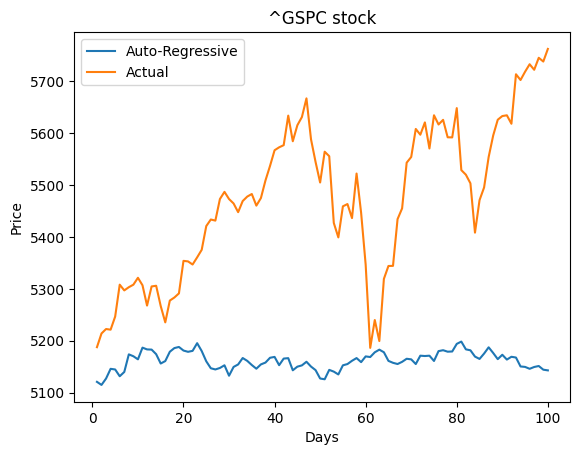

[*********************100%***********************]  1 of 1 completed

^DJI


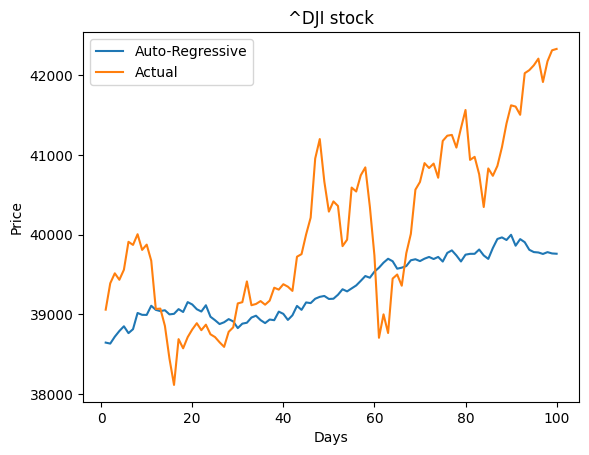

[*********************100%***********************]  1 of 1 completed

VIIIX


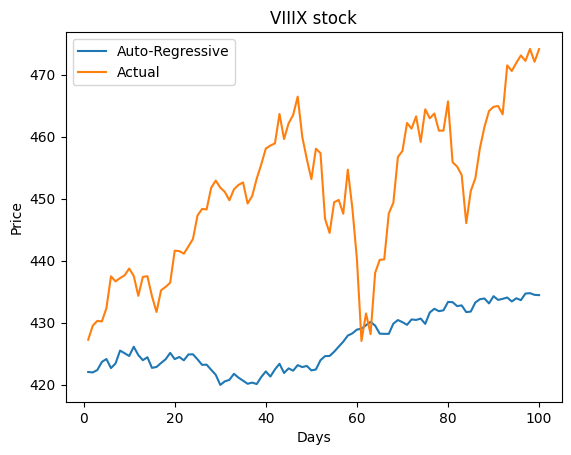

[*********************100%***********************]  1 of 1 completed

VOO


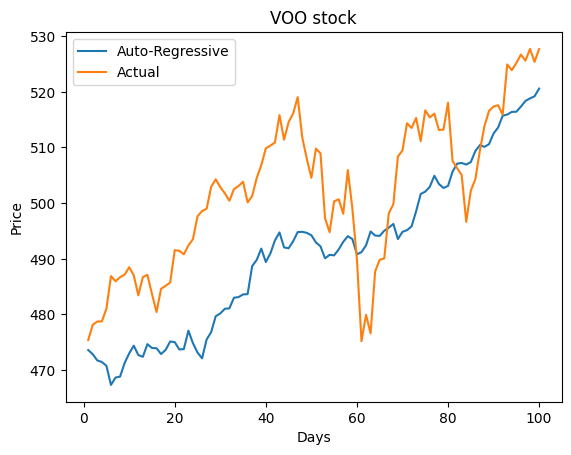

[*********************100%***********************]  1 of 1 completed

IVV


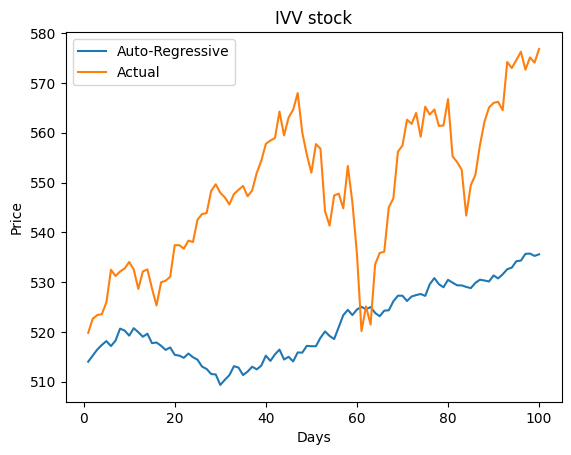

In [53]:
# This function does everything we just showed
stock_list = ["^GSPC", "^DJI", "VIIIX", "VOO", "IVV"] # list of index funds
temp_stock = ['^GSPC', '1980-01-01', '2024-10-01']

for i in stock_list:
    temp_stock[0] = i
    print(i)
    test_stock(temp_stock, restrict=100)